<a href="https://colab.research.google.com/github/Bhavya05shah/Lane_detection/blob/main/IVDC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def process_lane_image(image_path):
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    #Reducing noise and converting to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    #Edge detection
    edges = cv2.Canny(blurred, 50, 150)
    cv2_imshow(edges)

    #Masking the ROI(Region of Interest)
    mask = np.zeros_like(edges)
    height, width = image.shape[:2]
    ### The multiplying factor varies from image to image , so needs fine tuning w.r.t the image
    bottom_left  = [width * 0.1, height ]
    top_left     = [width * 0.45, height * 0.6]
    bottom_right = [width * 0.95, height ]
    top_right    = [width * 0.55, height * 0.6]
    #polygon = [(int(width*0.1), height), (int(width*0.45), int(height*0.6)), (int(width*0.55), int(height*0.6)), (int(0.95*width), height)]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    # filling the polygon with white color and generating the final mask
    cv2.fillPoly(mask, vertices, 255)
    # performing Bitwise AND on the input image and mask to get only the edges on the road
    masked_image = cv2.bitwise_and(edges, mask)
    cv2_imshow(masked_image)
    return masked_image,polygon

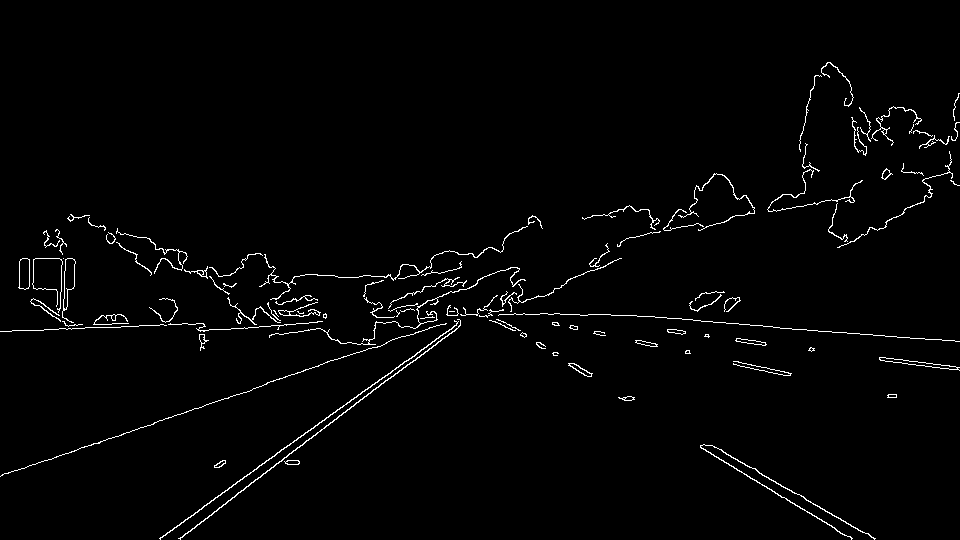

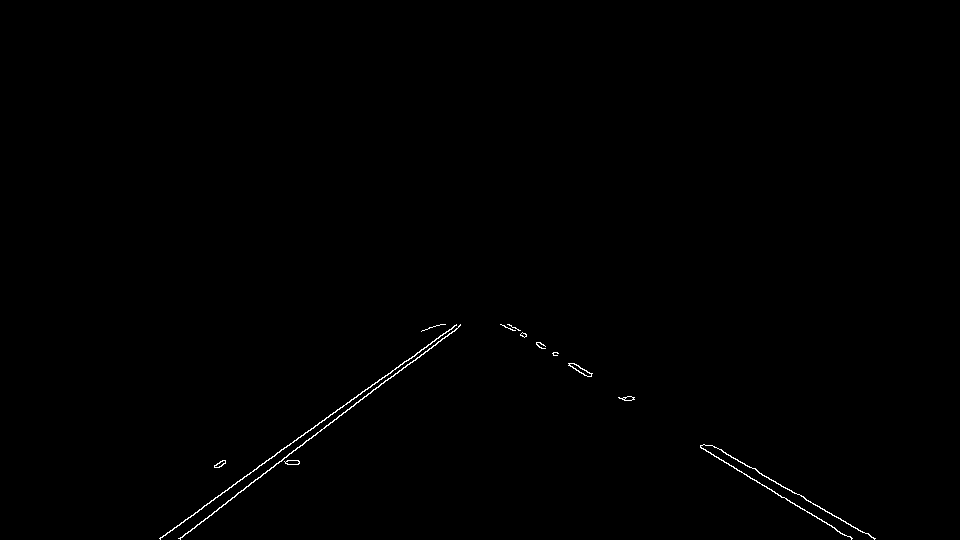

In [36]:
processed_image,polygon = process_lane_image('/content/good_lane_image.webp')

[[[219 507 460 325]]

 [[160 539 456 324]]

 [[504 325 874 538]]

 [[701 448 851 538]]

 [[503 325 874 539]]

 [[159 538 365 389]]

 [[618 397 852 538]]

 [[515 330 875 538]]

 [[342 407 456 325]]

 [[180 538 454 331]]

 [[568 365 707 445]]

 [[179 538 457 328]]

 [[508 324 634 397]]

 [[500 324 783 487]]]


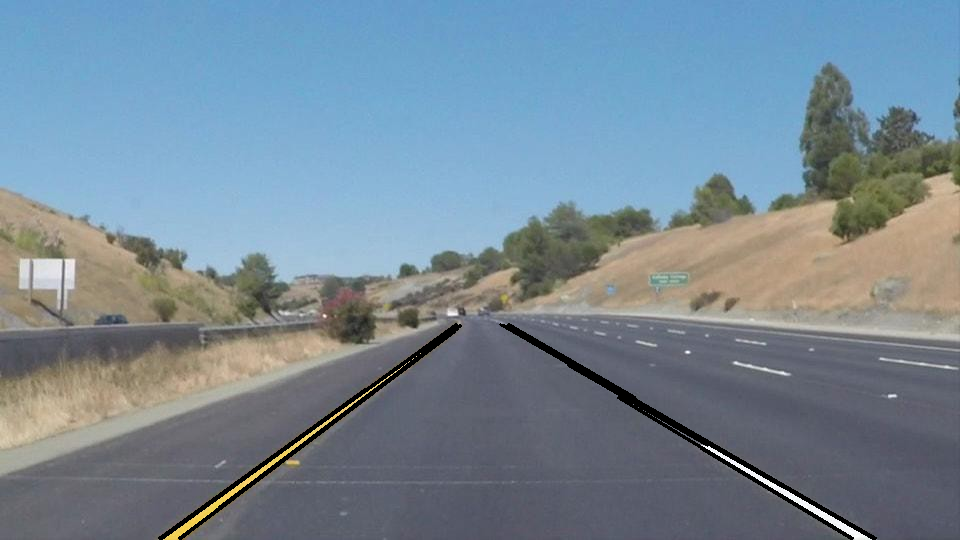

In [37]:
#Hough Transform will give us the lines forming the lanes
def Hough_Transform(masked_edges,image_path):
    lines = cv2.HoughLinesP(masked_edges, rho=1, theta=np.pi/180, threshold=20, minLineLength=20, maxLineGap=400)
    print(lines)
    return lines

lines = Hough_Transform(processed_image,'/content/good_lane_image.webp')
lane_image=cv2.imread('/content/good_lane_image.webp')
# Draw the detected lane lines
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(lane_image, (x1, y1), (x2, y2), (0, 0, 0), 2)

cv2_imshow(lane_image)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [38]:
image = cv2.imread('/content/good_lane_image.webp')
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
binary_image = np.ones_like(gray_image) * 255

if lines is not None:
    left_lane_points = []
    right_lane_points = []
    left_lane_slope=0
    right_lane_slope=0
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = (y2 - y1) / (x2 - x1)
        if slope < 0:  # Left lane
            left_lane_slope= left_lane_slope+slope
            left_lane_points.extend([(x1, y1), (x2, y2)])
        else:  # Right lane
            right_lane_slope=right_lane_slope+slope
            right_lane_points.extend([(x1, y1), (x2, y2)])

    # Sorting the points for proper polygon creation
    # Sorting by y-coordinate(ascending)
    left_lane_points = sorted(left_lane_points, key=lambda point: point[1])
    #Reverse sorting by y-cordinate(descending as for the right lane the x,y both increase when you go down the lane)
    right_lane_points = sorted(right_lane_points, key=lambda point: point[1], reverse=True)


    ### IF for some reason the bottom part of the road is not detected(which is quite important)
    ### the below code will identify the bottomost points of the lanes via thier slope and append it

    # left_lane_slope=left_lane_slope/(len(left_lane_points)/2)
    # right_lane_slope=right_lane_slope/(len(right_lane_points)/2)

    # height,width = image.shape[:2]
    # x_left_new = left_lane_points[len(left_lane_points)-1][0] - ((left_lane_points[len(left_lane_points)-1][1] - height)/left_lane_slope)
    # y_left_new = height
    # x_right_new = right_lane_points[0][0] + ((right_lane_points[0][1] - height)/right_lane_slope)
    # y_right_new = height

    # # To add the new lines
    # new_line1 = [[[int(x_left_new),int(y_left_new),left_lane_points[len(left_lane_points)-1][0],left_lane_points[len(left_lane_points)-1][1]]]]
    # new_line2 = [[[int(x_right_new),int(y_right_new), right_lane_points[0][0],right_lane_points[0][1]]]]
    # lines = np.vstack([lines, new_line1,new_line2])
    # # print(lines)
    # for line in lines:
    #     x1, y1, x2, y2 = line[0]
    #     cv2.line(lane_image, (x1, y1), (x2, y2), (0, 0, 0), 2)

    # left_lane_points.append((int(x_left_new),int(y_left_new)))
    # right_lane_points.append((int(x_right_new),int(y_right_new)))


    # Combine points to form the lane polygon
    lane_polygon = np.array([left_lane_points + right_lane_points], np.int32)
    # cv2.polylines(binary_image, [lane_polygon], isClosed=False, color=0, thickness=10)
    # print(lane_polygon)
    # Fill the region between the lanes with black (0)
    cv2.fillPoly(binary_image, lane_polygon, 0)


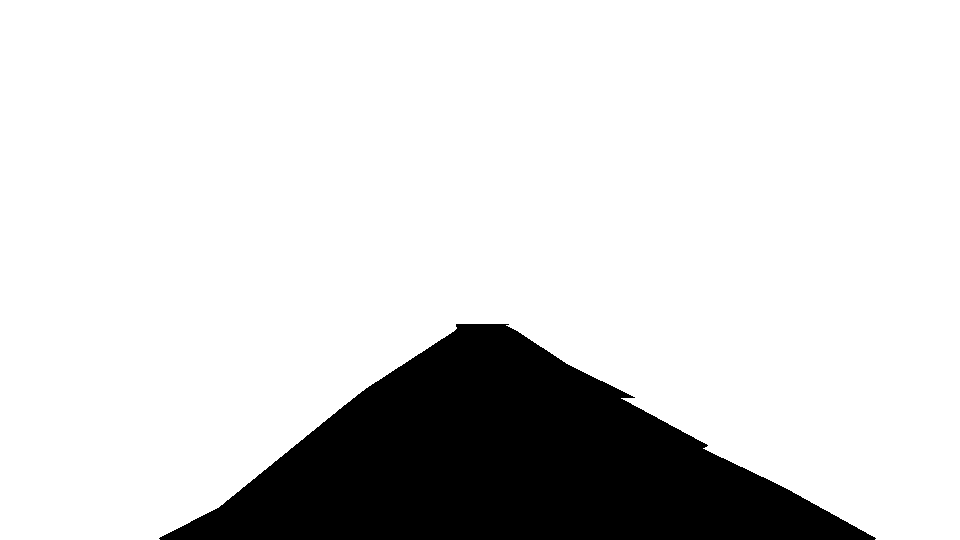

In [39]:
cv2_imshow(binary_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

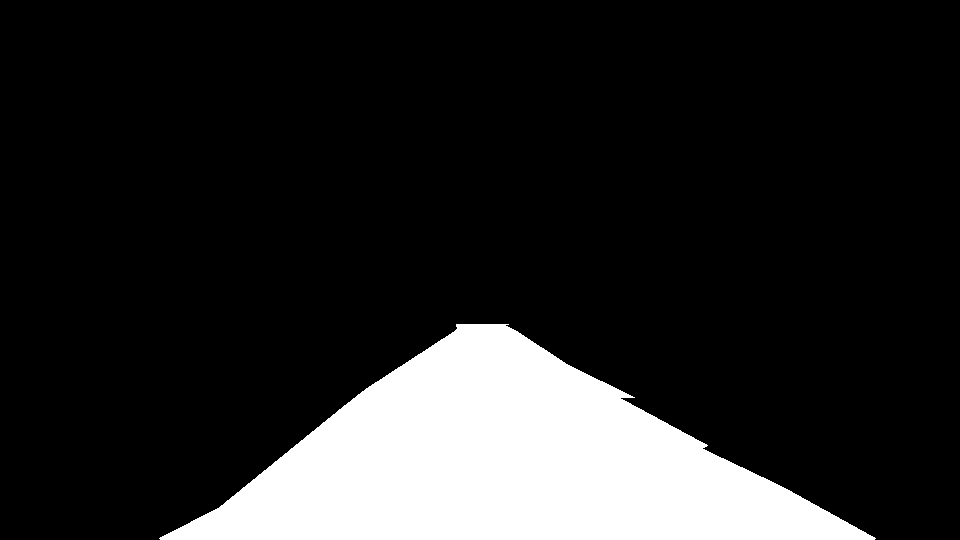

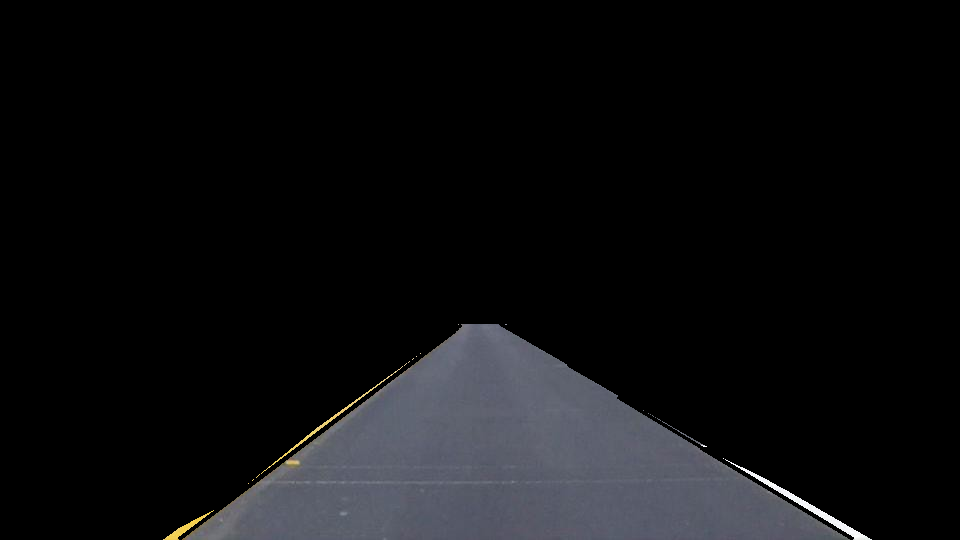

In [40]:
lane_mask = np.zeros_like(gray_image)
cv2.fillPoly(lane_mask, [lane_polygon], 255)  # White area for lanes, black for background

#Convert lane mask to 3-channel image
lane_mask_colored = cv2.cvtColor(lane_mask, cv2.COLOR_GRAY2BGR)
cv2_imshow(lane_mask_colored)

#Apply the lane_mask from above to the original image (subtracting the background)
lane_only_image = cv2.bitwise_and(lane_image, lane_mask_colored)
cv2_imshow(lane_only_image)

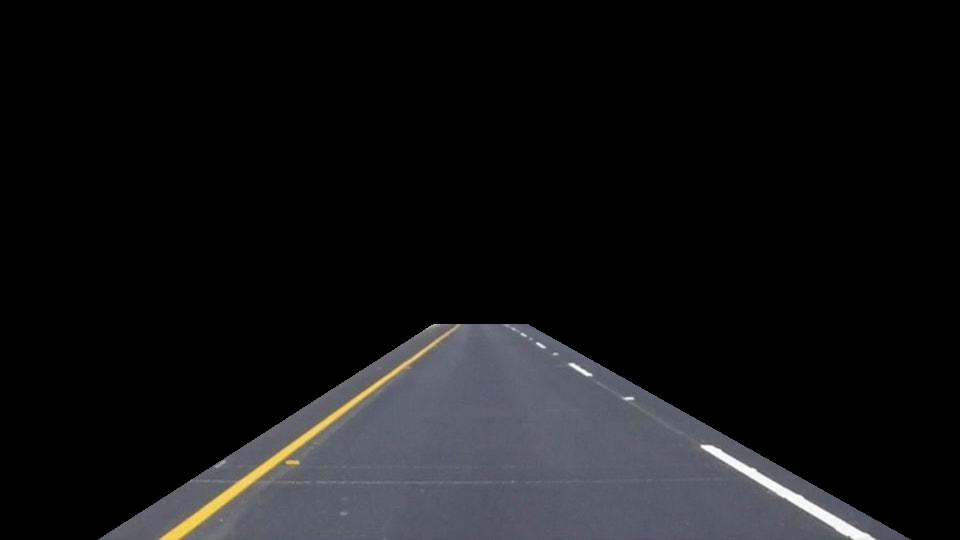

In [32]:
### Found on github to calculate the ROI for a staright lane detection

def regionOfInterest(img, polygon):
    mask = np.zeros_like(img)
    x1, y1 = polygon[0]
    x2, y2 = polygon[1]
    x3, y3 = polygon[2]
    x4, y4 = polygon[3]
    m1 = (y2-y1)/(x2-x1)
    m2 = (y3-y2)/(x3-x2)
    m3 = (y4-y3)/(x4-x3)
    m4 = (y4-y1)/(x4-x1)
    b1 = y1 - m1*x1
    b2 = y2 - m2*x2
    b3 = y3 - m3*x3
    b4 = y4 - m4*x4

    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if i>=m1*j+b1 and i>=m2*j+b2 and i>=m3*j+b3 and i<=m4*j+b4:
                mask[i][j] = 1

    masked_img = np.multiply(mask, img)
    return masked_img

lane_image=cv2.imread('/content/good_lane_image.webp')
height, width = lane_image.shape[:2]
polygon = [(int(width*0.1), height), (int(width*0.45), int(height*0.6)), (int(width*0.55), int(height*0.6)), (int(0.95*width), height)]
exp_img = regionOfInterest(lane_image,polygon)
cv2_imshow(exp_img)